In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import shutil
import numpy as np
from scipy import stats
from tqdm import tqdm
from IPython.display import clear_output
import re

import py21cmfish
from py21cmfish.power_spectra import *
from py21cmfish.io import *

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)

from scripts.step_size import *

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file(f"{WDIR}/matplotlibrc")

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:59: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:43: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


Default cache dir: /n/netscratch/iaifi_lab/Lab/yitians/dm21cm/21cmFAST-cache


In [2]:
noise_dir = "/n/home07/yitians/dm21cm/21cmSense_fid_EOS21/"
outputs_dir = "/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs"

## 1. 21cmFISH standard astrophysics

In [3]:
bkg_dir = f"{outputs_dir}/bkg/"

astro_params_vary = ['DM', 'F_STAR10', 'F_STAR7_MINI', 'ALPHA_STAR', 'ALPHA_STAR_MINI', 't_STAR',
                     'F_ESC10', 'F_ESC7_MINI', 'ALPHA_ESC', 'L_X', 'L_X_MINI', 'NU_X_THRESH', 'A_LW']
default_param_values = [0, -1.25, -2.5, 0.5, 0.0, 0.5, -1.35, -1.35, -0.3, 40.5, 40.5, 500, 2.0]

astro_params_vary = list(np.array(astro_params_vary))
default_param_values = default_param_values
astro_params_fid = dict()
for i in range(len(astro_params_vary)):
    astro_params_fid[astro_params_vary[i]] = default_param_values[i]
    
# Load each parameter into a dictionary
params_EoS = {}
for param in astro_params_vary[1:]:
    params_EoS[param] = py21cmfish.Parameter(
        HII_DIM=128, BOX_LEN=256, param=param,
        output_dir = bkg_dir,
        PS_err_dir = noise_dir,
        new = False
)
clear_output()

## 2. Fisher analysis at each mass

In [21]:
run_name = 'pbhacc-PRc50-250428'
channel = run_name.rsplit('-', 1)[0]
inj_dir = f"{outputs_dir}/active/{run_name}"
print(os.listdir(inj_dir))

# Get the simulated masses of the injected signal
log10m_s = np.sort([
    float(re.match(r'log10m([-\d\.]+)', d).group(1))
    for d in os.listdir(inj_dir)
    if re.match(r'log10m([-\d\.]+)', d)
])
# log10m_s = np.sort(log10m_s)
m_s = 10**log10m_s
print('log10m_s', log10m_s)

EPSILON = 1e-6

if channel == 'decay-phot':
    tau_s = decay_phot_lifetime(m_s)
    inj_s = 1/tau_s
elif channel == 'decay-elec':
    tau_s = decay_elec_lifetime(m_s)
    inj_s = 1/tau_s
elif channel == 'pwave-phot':
    c_s = pwave_phot_c_sigma(m_s)
    inj_s = c_s
elif channel == 'pwave-elec':
    c_s = pwave_elec_c_sigma(m_s)
    inj_s = c_s
elif channel == 'pwave-tau':
    c_s = pwave_tau_c_sigma(m_s)
    inj_s = c_s
elif channel.startswith('pbhhr'):
    f_s = pbhhr_f(m_s)
    inj_s = f_s
elif channel.startswith('pbhacc'):
    model = channel.split('-')[1]
    f_s = pbhacc_f(m_s, model)
    inj_s = f_s

['log10m3.000', 'log10m0.000', 'log10m1.000', 'log10m2.000', 'log10m4.000']
log10m_s [0. 1. 2. 3. 4.]


In [22]:
# Copy the fiducial lightcone in each mass directory
print('Copied :', end=' ')
for m in m_s:
    source_file = f'{bkg_dir}/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5'
    target_file = f'{inj_dir}/log10m{np.log10(m):.3f}/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5'
    if not os.path.isfile(target_file):
        print(f'{np.log10(m):.3f}', end=' ')
        shutil.copyfile(source_file, target_file)

Copied : 

In [28]:
sigma_s = []
force_new = False

for m in tqdm(m_s):

    lc_dir = f'{inj_dir}/log10m{np.log10(m):.3f}/'
    new = ('lc_redshifts.npy' not in os.listdir(lc_dir)) or force_new
    
    for param in astro_params_vary[:1]:
        params_EoS[param] = py21cmfish.Parameter(
            HII_DIM=128, BOX_LEN=256, param=param,
            output_dir=lc_dir,
            PS_err_dir=noise_dir, new=new,
        )

    Fij_matrix_PS, Finv_PS= py21cmfish.make_fisher_matrix(
        params_EoS,
        fisher_params=astro_params_vary,
        hpeak=0.0, obs='PS',
        k_min=0.1, k_max=1,
        sigma_mod_frac=0.2,
        add_sigma_poisson=True
    )
    sigma_s.append(np.sqrt(Finv_PS[0, 0]))
    
sigma_s = np.array(sigma_s)
print('sigma', sigma_s)

  0%|          | 0/5 [00:00<?, ?it/s]

########### fisher set up for DM
    Loaded redshifts
    Loaded redshifts
    Loaded T(z) from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m0.000/global_signal_dict_DM.npy
    Loaded param values from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m0.000/params_dict_DM.npy
    Loading global signal and power spectra from saved files
    Loaded PS from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m0.000/power_spectrum_dict_DM.npy
    Loaded fiducial PS from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m0.000/power_spectrum_fid_21cmsense.npy, shape:(23, 46)
    Loading 21cmsense errors from /n/home07/yitians/dm21cm/21cmSense_fid_EOS21/


 20%|██        | 1/5 [00:00<00:02,  1.46it/s]

    Loaded PS_z_HERA from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m0.000/PS_z_HERA.npy shape= (23,)
    Loaded GS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m0.000/global_signal_deriv_dict_DM.npy
    Loaded PS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m0.000/power_spectrum_deriv_dict_DM.npy shape= (69, 46)
    Loading Poisson noise for PS
    Fiducial: DM=1
PS shape: (23, 24)
########### fisher set up for DM
    Loaded redshifts
    Loaded redshifts
    Loaded T(z) from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m1.000/global_signal_dict_DM.npy
    Loaded param values from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m1.000/params_dict_DM.npy
    Loading global signal and power spectra from saved files
    Loaded P

 40%|████      | 2/5 [00:01<00:02,  1.47it/s]

    Loaded PS_z_HERA from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m1.000/PS_z_HERA.npy shape= (23,)
    Loaded GS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m1.000/global_signal_deriv_dict_DM.npy
    Loaded PS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m1.000/power_spectrum_deriv_dict_DM.npy shape= (69, 46)
    Loading Poisson noise for PS
    Fiducial: DM=1
PS shape: (23, 24)
########### fisher set up for DM
    Loaded redshifts
    Loaded redshifts
    Loaded T(z) from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m2.000/global_signal_dict_DM.npy
    Loaded param values from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m2.000/params_dict_DM.npy
    Loading global signal and power spectra from saved files
    Loaded P

 60%|██████    | 3/5 [00:02<00:01,  1.46it/s]

    Loaded PS_z_HERA from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m2.000/PS_z_HERA.npy shape= (23,)
    Loaded GS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m2.000/global_signal_deriv_dict_DM.npy
    Loaded PS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m2.000/power_spectrum_deriv_dict_DM.npy shape= (69, 46)
    Loading Poisson noise for PS
    Fiducial: DM=1
PS shape: (23, 24)
########### fisher set up for DM
    Loaded redshifts
    Loaded redshifts
    Loaded T(z) from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m3.000/global_signal_dict_DM.npy
    Loaded param values from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m3.000/params_dict_DM.npy
    Loading global signal and power spectra from saved files
    Loaded P

 80%|████████  | 4/5 [00:02<00:00,  1.47it/s]

    Loaded PS_z_HERA from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m3.000/PS_z_HERA.npy shape= (23,)
    Loaded GS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m3.000/global_signal_deriv_dict_DM.npy
    Loaded PS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m3.000/power_spectrum_deriv_dict_DM.npy shape= (69, 46)
    Loading Poisson noise for PS
    Fiducial: DM=1
PS shape: (23, 24)
########### fisher set up for DM
    Loaded redshifts
    Loaded redshifts
    Loaded T(z) from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m4.000/global_signal_dict_DM.npy
    Loaded param values from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m4.000/params_dict_DM.npy
    Loading global signal and power spectra from saved files
    Loaded P

100%|██████████| 5/5 [00:03<00:00,  1.47it/s]

    Loaded PS_z_HERA from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m4.000/PS_z_HERA.npy shape= (23,)
    Loaded GS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m4.000/global_signal_deriv_dict_DM.npy
    Loaded PS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc50-250428/log10m4.000/power_spectrum_deriv_dict_DM.npy shape= (69, 46)
    Loading Poisson noise for PS
    Fiducial: DM=1
PS shape: (23, 24)
sigma [283.76906603 212.96615457 229.08776552 236.89931762 244.71165173]


In [29]:
# check sigma as a multiple of step size. recommended: 30-100
sigma_s

array([283.76906603, 212.96615457, 229.08776552, 236.89931762,
       244.71165173])

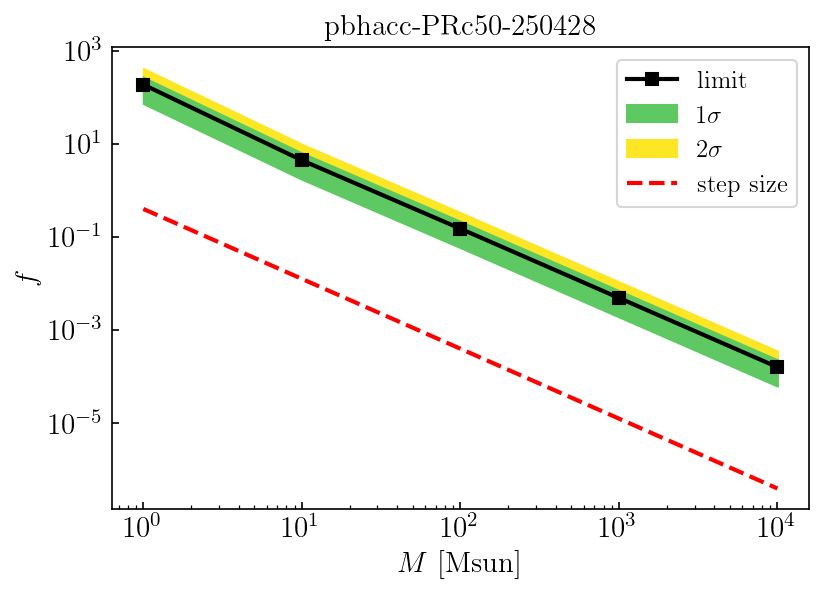

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

one_sigma = inj_s * sigma_s
upper_limit = np.sqrt(stats.chi2.ppf(.9, df=1)) * one_sigma

ax.plot(m_s, upper_limit, 'k-s', label='limit')
ax.fill_between(m_s, upper_limit + one_sigma, upper_limit - one_sigma, color=mpl.colormaps['viridis'](0.75), label='1$\sigma$')
ax.fill_between(m_s, upper_limit + 2*one_sigma, upper_limit + one_sigma, color=mpl.colormaps['viridis'](1.0), label='2$\sigma$')

ax.set(xscale='log', yscale='log')
ax.set(title=run_name)

m_fine_s = np.geomspace(m_s[0], m_s[-1], 100)
if channel == 'decay-phot':
    ax.plot(m_fine_s, 1/decay_phot_lifetime(m_fine_s), 'r--', label='step size')
    ax.set(xlabel=r'$m_\chi$ [eV]', ylabel=r'$1/\tau$ [s$^{-1}$]')
elif channel == 'decay-elec':
    ax.plot(m_fine_s, 1/decay_elec_lifetime(m_fine_s), 'r--', label='step size')
    ax.set(xlabel=r'$m_\chi$ [eV]', ylabel=r'$1/\tau$ [s$^{-1}$]')
elif channel == 'pwave-phot':
    ax.plot(m_fine_s, pwave_phot_c_sigma(m_fine_s), 'r--', label='step size')
    ax.set(xlabel=r'$m_\chi$ [eV]', ylabel=r'$C_\sigma$ [cm$^3$/s]')
elif channel == 'pwave-elec':
    ax.plot(m_fine_s, pwave_elec_c_sigma(m_fine_s), 'r--', label='step size')
    ax.set(xlabel=r'$m_\chi$ [eV]', ylabel=r'$C_\sigma$ [cm$^3$/s]')
elif channel == 'pwave-tau':
    ax.plot(m_fine_s, pwave_tau_c_sigma(m_fine_s), 'r--', label='step size')
    ax.set(xlabel=r'$m_\chi$ [eV]', ylabel=r'$C_\sigma$ [cm$^3$/s]')
elif channel.startswith('pbhhr'):
    ax.plot(m_fine_s, pbhhr_f(m_fine_s), 'r--', label='step size')
    ax.set(xlabel=r'$M$ [g]', ylabel=r'$f$')
elif channel.startswith('pbhacc'):
    ax.plot(m_fine_s, pbhacc_f(m_fine_s, model), 'r--', label='step size')
    ax.set(xlabel=r'$M$ [Msun]', ylabel=r'$f$')
ax.legend()

In [20]:
save_fn = f'../outputs/limits/{run_name}.txt'
dir_path = os.path.dirname(save_fn)
os.makedirs(dir_path, exist_ok=True)
np.savetxt(save_fn, np.array([m_s, inj_s, sigma_s]).T, header='mass_s inj_s sigma_s')

# Comparison

In [31]:
from scripts.step_size import *

# recommended: 30-100
print(sigma_s)
print(sigma_s * pbhacc_f_old(m_s, 'PRc50') / pbhacc_f(m_s, 'PRc50'))

[283.76906603 212.96615457 229.08776552 236.89931762 244.71165173]
[112.97049997  84.78335322  91.20148214  94.31131704  97.42146327]
